# Choosing features

In [1]:
import numpy as np

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

# Load datasets
X_train = np.load('../FinalDataset/X_train.npy')
X_test = np.load('../FinalDataset/X_test.npy')
y_train = np.load('../FinalDataset/y_train.npy')
y_test = np.load('../FinalDataset/y_test.npy')

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}
X_train shape:  (126, 500, 3)
X_test shape:  (54, 500, 3)
y_train shape:  (126,)
y_test shape:  (54,)


In [7]:

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tsfel

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_features = tsfel.time_series_features_extractor(cfg, X_train, verbose=1, fs=50)
X_test_features = tsfel.time_series_features_extractor(cfg, X_test, verbose=1, fs=50)

# Remove highly correlated features
correlated_features = tsfel.correlated_features(X_train_features)
X_train_filtered = X_train_features.drop(correlated_features, axis=1)
X_test_filtered = X_test_features.drop(correlated_features, axis=1)

# Remove low variance features
variance_selector = VarianceThreshold(threshold=0)
X_train_reduced = variance_selector.fit_transform(X_train_filtered)
X_test_reduced = variance_selector.transform(X_test_filtered)

# Normalize features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_test_normalized = scaler.transform(X_test_reduced)

# Apply PCA

pca = PCA(n_components=20)
X_train_pca_20 = pca.fit_transform(X_train_normalized)
X_test_pca_20 = pca.transform(X_test_normalized)

print("X_train_pca shape: ", X_train_pca_20.shape)
print("X_test_pca shape: ", X_test_pca_20.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
X_train_pca shape:  (126, 20)
X_test_pca shape:  (54, 20)


In [8]:
import pandas as pd
display(pd.DataFrame(X_train_pca_20).head())

print("PCA Explained Variance: ", pca.explained_variance_ratio_)
print("PCA Explained Variance Sum: ", sum(pca.explained_variance_ratio_))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.654582,-5.899236,-1.106172,-0.215393,-1.188857,2.827502,-1.846816,1.390700,2.086636,4.461138,-1.577499,-4.231603,-1.318772,0.709768,0.423149,-4.196450,0.598293,-1.805687,-2.132253,3.400615
1,-13.996420,4.018117,0.806464,-0.614586,-0.997608,-2.447898,1.889782,-2.213029,2.060404,1.479803,-1.363005,-3.143069,-0.781966,-0.607239,-0.226870,0.948589,-0.082969,0.791263,0.566574,-0.955101
2,-12.981227,0.833213,-0.304781,-0.295977,0.277471,0.875163,-1.009337,0.880470,-0.961859,-0.879818,1.537585,2.001917,0.302973,0.126857,0.446116,-1.382957,0.681845,-0.809629,-0.837953,1.416460
3,3.479370,-4.684510,-2.146132,1.031565,-1.216163,1.295139,-0.557989,3.058410,2.141187,2.092606,-1.054642,-3.324538,0.386131,-0.624112,-2.198317,-4.391228,-0.292968,0.085840,-0.203628,1.887560
4,5.807162,-5.761255,0.067558,3.379331,-2.263407,0.684044,-2.527770,-1.915973,-0.521737,1.168231,0.619647,-0.967745,-0.791144,0.793520,-1.913577,-1.265076,-1.128570,-2.481596,-6.972046,-1.496635


PCA Explained Variance:  [0.28703436 0.03779485 0.03279609 0.03077337 0.02917731 0.02607383
 0.02319691 0.02129459 0.02048456 0.01975598 0.01824387 0.01778319
 0.01662608 0.01638779 0.0161602  0.01482367 0.01456554 0.01343689
 0.01304301 0.01271207]
PCA Explained Variance Sum:  0.6821641610834951


In [4]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd


# Fit a Decision Tree classifier to get feature importances
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_normalized, y_train)

# Get feature importances
importances = clf.feature_importances_
# Number of top features you want
N = 6
# Get indices of the top N features
top_indices = np.argsort(importances)[-N:]

filtered_feature_names = X_train_filtered.columns
# Get feature names corresponding to the top N features
top_feature_names = [filtered_feature_names[i] for i in top_indices]

# Select the top N important features from the datasets
X_test_important = X_test_normalized[:, top_indices]



# Display the shapes and feature names
print("X_test_important shape: ", X_test_important.shape)
print("Top feature names: ", top_feature_names)


# Display the dataframes with the top features
df_test_important = pd.DataFrame(X_test_important, columns=top_feature_names)

prefix_map = {
    '0': 'x',
    '1': 'y',
    '2': 'z',
    '3': 'linear_acceleration'
}

# Create a new column name mapping
new_columns = {}
for col in df_test_important.columns:
    prefix = col.split('_')[0]
    if prefix in prefix_map:
        new_prefix = prefix_map[prefix]
        new_col_name = col.replace(prefix, new_prefix)
        new_columns[col] = new_col_name

# Rename the columns
df_test_important.rename(columns=new_columns, inplace=True)
top_feature_names = list(df_test_important.columns)

display(df_test_important)

X_test_important shape:  (54, 6)
Top feature names:  ['1_FFT mean coefficient_205', '0_Min', '1_MFCC_11', '0_FFT mean coefficient_95', '0_FFT mean coefficient_204', '0_ECDF Percentile Count_0']


,y_FFT mean coefficient_205,x_Min,y_MFCC_yy,x_FFT mean coefficient_95,x_FFT mean coefficient_2x4,x_ECDF Percentile Count_x
0,4.808412,-0.716924,0.874209,1.276809,0.413246,0.111214
1,-0.366802,-0.841201,1.227735,0.116074,-0.311291,0.220641
2,-0.362164,-1.451714,-0.398786,0.645658,-0.150772,-0.190568
3,-0.399911,-0.066238,0.716442,-0.782123,-0.316134,0.918342
4,-0.419538,-0.445348,-0.777930,-0.782280,-0.316125,0.938693
5,-0.322650,-0.454454,0.420472,0.403481,-0.206312,0.112655
6,0.332104,-0.742754,0.522770,-0.245254,1.982055,0.351388
7,-0.417714,-0.114917,0.010382,-0.782296,-0.316132,0.996954
8,0.977106,-0.915073,0.957663,3.480592,0.839654,-0.333248
9,-0.112113,-0.951475,-0.903476,0.184108,-0.181325,0.103793


# Zero Shot
Since we aren't giving the labels to the LLM .The only source of information the LLM coud get was from only the training data.<br> So rather than reducing the feature number by PCA , I decided to choose top k features using decision tree feature im portance.

Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 4
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 4
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 6
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 6
True label for the query input: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label for the query input: 4
True label for the query input: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label for the query input: 6
True label for the query input: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label for the query input: 6
True label for the query input: 1


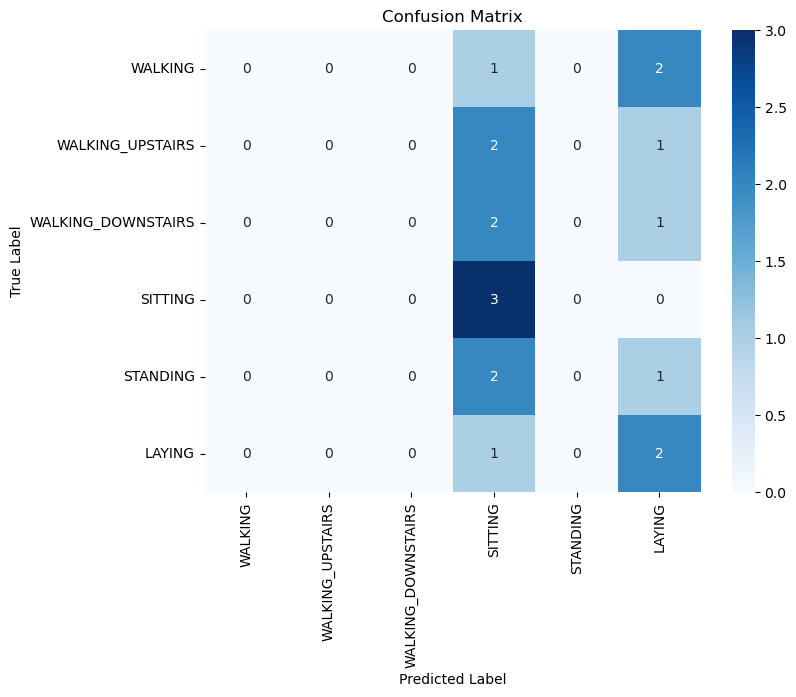

Total tokens used: 8345


In [5]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize token count
token_count = 0

def make_api_call(prompt):
    global token_count
    while True:
        try:
            response = llm.invoke(prompt)
            token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Set up your Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Function to generate a zero-shot prompt
# Function to generate a zero-shot prompt
def create_zero_shot_prompt(query_input, retained_features):
    """Generate a prompt for the model given the JSON formatted data and retained features."""
    # Combine features and their corresponding values in "column:value" format
    features_str = ', '.join([f"{feature}:{value}" for feature, value in zip(retained_features, query_input)])

    description = (f"""
    You are a highly trained human activity classification model.
    Each input is a vector containing numerical values that represent specific features of human activity data.
    The data is presented as pairs of column names and their corresponding values.

    The data consists of {N} features extracted from the Human Activity Recognition dataset. 
    Your task is to analyze the given input vector and classify the human activity into one of the following categories:
    - 1: WALKING
    - 2: WALKING_UPSTAIRS
    - 3: WALKING_DOWNSTAIRS
    - 4: SITTING 
    - 5: STANDING
    - 6: LAYING

    The initial data consisted of:
    - 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.

    Data Format:
    - Static activities tend to have very little variation in the accelerometer data, while dynamic activities tend to have more variation.
    - x axis is the vertical axis, z axis is forward direction, and y axis is the side direction.
    - Acceleration is measured in terms of g-force. At rest, the acceleration is 1 (representing gravity).

    The following input vector represents the selected features and their corresponding values: {features_str}

    Now, classify this input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.
    """)

    return description

# Step 3: Select 3 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = X_test_important[idx].tolist()
    true_label = y_test[idx]
    prompt = create_zero_shot_prompt(query_input, top_feature_names)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print token usage
print(f"Total tokens used: {token_count}")


# Few Shot
PCA is applied on featurised data and passed to LLM for prediction.
30 few shot examples are given to the LLM for learning.

Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 3
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1


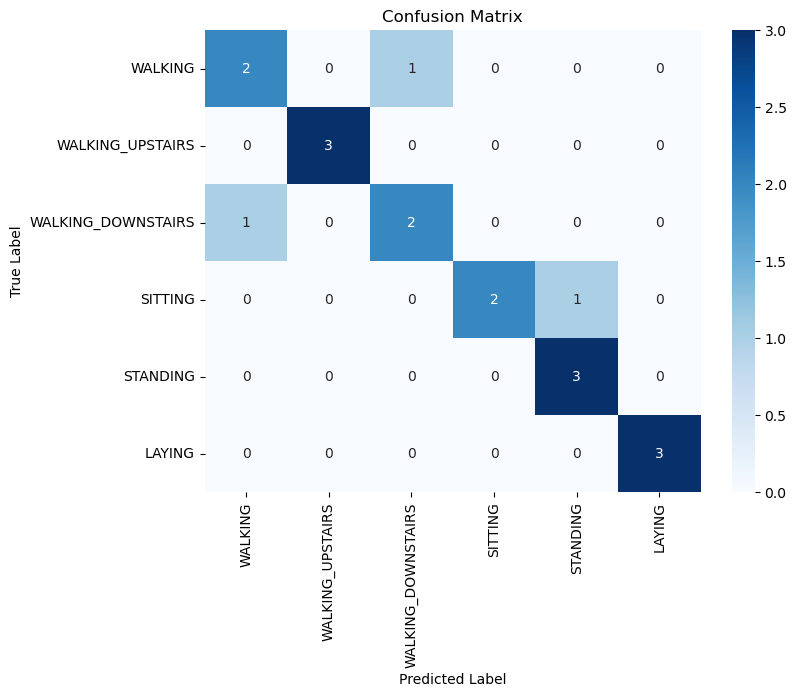

Total tokens used: 104541


In [12]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize token count
token_count = 0

def make_api_call(prompt):
    global token_count
    while True:
        try:
            response = llm.invoke(prompt)
            token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Step 1: Set up your Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Step 2: Prepare your few-shot learning prompt
#  Initialize necessary variables
few_shot_indices = []
samples_per_activity = 5  # Set the desired number of samples per activity for few-shot examples
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

# Loop through the training data to select even samples
for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create the few-shot examples with even distribution
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]


def create_few_shot_prompt(examples, query_input):
    # Description of the data and task
    description = ('''
        You are a highly trained human activity classification model.
        Each input is a vector containing numerical values that represent transformed features.
        The data is presented as comma-separated values in a list format.
        The data consists of 20 principal components extracted from the Human Activity Recognition dataset. 
        Your task is to analyze the given input vector and classify the human activity into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING
        Here are a few examples:\n'''
    )

    # Build the prompt with examples and the new query
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n"
        
    query_input_str = ",".join(map(str, query_input))
    prompt += "Now, classify the following input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.\n"
    prompt += f"Input: [{query_input_str}]\nLabel: "
    return prompt

# Step 3: Select 3 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print token usage
print(f"Total tokens used: {token_count}")


In [13]:
# Check the label distribution
label_distribution = {i: 0 for i in range(1, 7)}
for example in few_shot_examples:
    label_distribution[example['label']] += 1

print("Label Distribution in Few-Shot Examples:")
for label, count in label_distribution.items():
    print(f"Label {label}: {count} occurrences")

Label Distribution in Few-Shot Examples:
Label 1: 5 occurrences
Label 2: 5 occurrences
Label 3: 5 occurrences
Label 4: 5 occurrences
Label 5: 5 occurrences
Label 6: 5 occurrences
